# STAREPandas Multiprocessing

In [1]:
import dask
import numpy
import starepandas
import geopandas
import pystare
import pandas
import matplotlib.pyplot as plt
import datetime

In [2]:
us_all = geopandas.read_file('../tests/data/tl_2017_us_state.gpkg')
us_all = us_all.to_crs('EPSG:4326')

In [3]:
us = us_all[0:25]
us

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677997539,1323452846,+41.5974187,-071.5272723,"MULTIPOLYGON (((-71.67881 41.15891, -71.67626 ..."
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,214048160737,2393355752,+44.3484222,-114.5588538,"POLYGON ((-116.89971 44.84061, -116.89967 44.8..."
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,23187445452,1028643155,+43.6726907,-071.5843145,"POLYGON ((-72.32990 43.60021, -72.32984 43.600..."
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,125919712692,13470113896,+35.5397100,-079.1308636,"POLYGON ((-82.41674 36.07283, -82.41660 36.073..."
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,23873457570,1031134839,+44.0604795,-072.6733274,"POLYGON ((-73.31328 44.26413, -73.31274 44.265..."


## Parallel SID lookup

In [4]:
def sids_from_geoseries(series, level, convex=False, force_ccw=True, n_workers=1):
    sids = []
    for geom in series:
        sids_row = starepandas.sids_from_shapely(geom=geom, level=level, convex=convex, force_ccw=force_ccw)
        sids.append(sids_row)
    sids = numpy.array(sids, dtype='object')  # Has to be object to suppress VisibleDeprecationWarning
    return sids

In [5]:
n_workers = 2

ddf = dask.dataframe.from_pandas(us.geometry, npartitions=n_workers)
meta = {'sids': 'uint64'}

res = ddf.map_partitions(lambda df: numpy.array(sids_from_geoseries(df, level=7, convex=False, force_ccw=True, n_workers=1), dtype='object'), 
                         meta=meta)

sids = res.compute(scheduler='processes')

### High level

In [6]:
stare = starepandas.sids_from_geoseries(us.geometry, 
                                        level=7, 
                                        convex=False, 
                                        force_ccw=True, 
                                        n_partitions=4)

# Parallel Trixel lookup

## Manual / low level

In [7]:
n_cores = 4

us['sids'] = stare
ddf = dask.dataframe.from_pandas(us['sids'], npartitions=n_cores)
meta = {'trixels': 'object'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.trixels_from_stareseries(df)), meta=meta)
trixels = res.compute(scheduler='processes')

/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## High level

In [8]:
stare = pandas.Series(stare)
trixels = starepandas.trixels_from_stareseries(stare, n_partitions=4)

# Parallel instantiation

In [9]:
us = starepandas.STAREDataFrame(us, 
                                add_sids=True, 
                                level=7, 
                                add_trixels=True, 
                                n_partitions=4)

<Axes: >

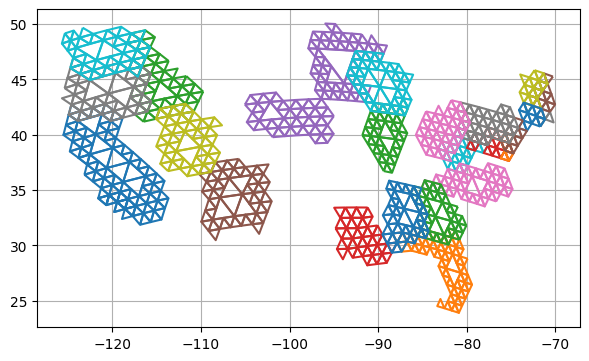

In [10]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

us.plot(ax=ax, trixels=True, column='NAME')

# Visualization

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,sids,trixels
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...","[3137320090416971783, 3164341688181194759, 316...","MULTIPOLYGON (((-79.56820 39.46980, -79.99541 ..."


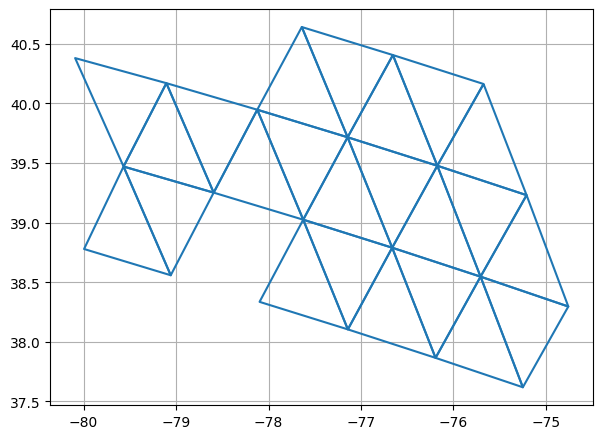

In [11]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

hawaii = us[us['NAME']=='Maryland']
hawaii.plot(ax=ax, trixels=True)
hawaii

# Parallel dissolve

In [12]:
us_regions = us.stare_dissolve(by='REGION', aggfunc='sum', num_workers=4, geom=False)

In [13]:
trixels = us_regions.make_trixels(n_partitions=4)
us_regions.set_trixels(trixels, inplace=True)

<Axes: >

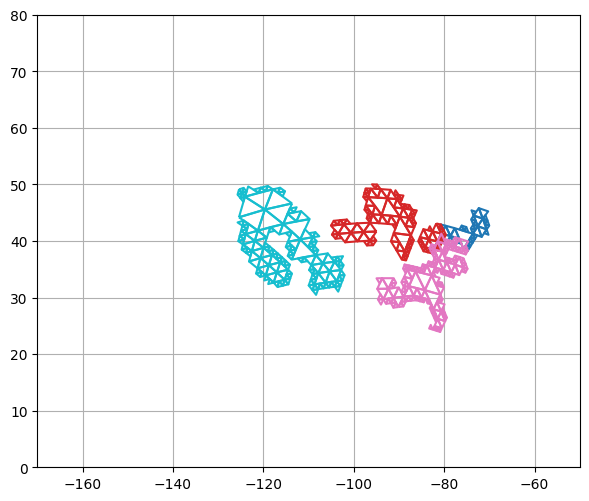

In [14]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

ax.set_xlim(-170, -50)
ax.set_ylim(0, 80)

us_regions.reset_index().plot(ax=ax, trixels=True, column='REGION')

# Parallel Intersects

## Cover

In [15]:
us = starepandas.STAREDataFrame(us, add_sids=True, 
                                level=6, add_trixels=True, n_partitions=4)

In [16]:
filepath = '../tests/data/granules/viirs/VNP03DNB.A2022308.1930.002.2022309041547.nc'
vnp03 = starepandas.io.granules.VNP03DNB(filepath)
vnp03.read_sidecar_cover()
vnp03_cover = vnp03.stare_cover
vnp03_cover_df = starepandas.STAREDataFrame({'sids': vnp03.stare_cover}, sids='sids', add_trixels=True)

<Axes: >

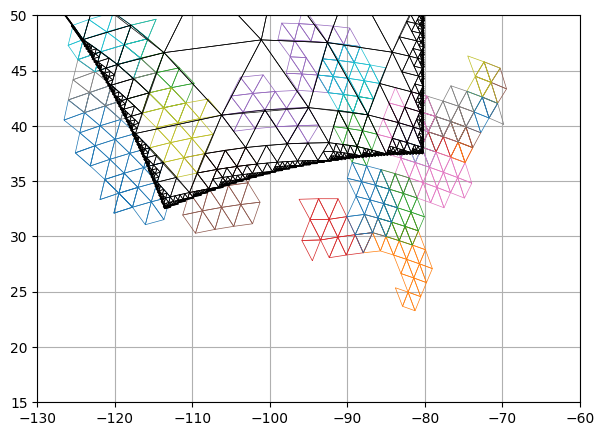

In [17]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

ax.set_xlim(-130, -60)
ax.set_ylim(15, 50)

us.plot(ax=ax, column='NAME', trixels=True, linewidth=0.5)
vnp03_cover_df.plot(ax=ax, trixels=True, color='k', linewidth=0.5)

In [ ]:
def series_intersects(other, series, method=1, n_workers=1):
    """ 
    Returns a bool series of length len(series).
    True for every row in which row intersects other.    
    """
    other = numpy.array([other]).flatten()
    
    if n_workers > len(series):
        # Cannot have more partitions than rows        
        n_workers = len(series) 
        
    if n_workers == 1:        
        if series.dtype in [numpy.dtype('uint64'), numpy.dtype('int64'), pandas.UInt64Dtype(), pandas.Int64Dtype()]:               
            # We have a series of sids; don't need to iterate. Can send the whole array to pystare/
            intersects = pystare.intersects(other, series, method)
        else:
            intersects = []   
            for sids in series:
                if isinstance(sids, str):
                    sids = numpy.array(sids.strip('[]').split(), dtype=numpy.int64)        
                if len(list(sids)) < len(other):
                    # If we do method 1, larger item first is faster
                    intersects.append(pystare.intersects(other, sids, method).any())
                else:
                    intersects.append(pystare.intersects(sids, other, method).any())
            intersects = numpy.array(intersects)
    else:
        ddf = dask.dataframe.from_pandas(series, npartitions=n_workers)
        meta = {'intersects': 'bool'}
        res = ddf.map_partitions(lambda df: series_intersects(other, df, method, 1), meta=meta)
        intersects = res.compute(scheduler='processes')    
    return intersects

In [19]:
a = numpy.array(vnp03_cover)

In [20]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['sids'] , 1, 1)
print(datetime.datetime.now() - start)

0:00:00.005978


In [21]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['sids'], 1, 5)
print(datetime.datetime.now() - start)

0:00:01.347456


In [22]:
intersects

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True])

In [23]:
print(list(us[intersects]['NAME']))

['West Virginia', 'Illinois', 'Minnesota', 'Maryland', 'Idaho', 'North Carolina', 'New Mexico', 'California', 'Wisconsin', 'Oregon', 'Nebraska', 'Pennsylvania', 'Washington', 'Utah', 'Ohio']


## iFOVs

In [42]:
import copy
filepath = '../tests/data/granules/viirs/VNP03DNB.A2022308.1930.002.2022309041547.nc'
vnp03 = starepandas.read_granule(filepath, sidecar=True, xy=True)
vnp03 = copy.copy(vnp03[vnp03.y<1500])

In [55]:
state_sids = us[us['NAME']=='Utah']['sids'].iloc[0]
state_sids

array([3341811660997263366, 3341952398485618694, 3342093135973974022,
       3342374610950684678, 3342515348439040006, 3342656085927395334,
       3342937560904105990, 3343078298392461318, 3343219035880816646,
       3343359773369171974, 3343500510857527302, 3343641248345882630,
       3343781985834237958, 3349130010391740422, 3349270747880095750,
       3349411485368451078, 3349552222856806406, 3349833697833517062,
       3349974435321872390, 3350115172810227718, 3350396647786938374,
       3350537385275293702])

In [56]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['sids'])
print(datetime.datetime.now() - start)

0:00:16.396078


In [50]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['sids'], 1, 60)
print(datetime.datetime.now() - start)

0:00:11.133490


In [57]:
intersects.sum()/vnp03.index.size

0.13730413385826773

In [59]:
vnp03[intersects]

,sids,x,y,moon_illumination_fraction,land_water_mask,quality_flag
1194175,3341882033058642606,3423,293,85.869995,1,0
1194176,3341882036842615342,3424,293,85.869995,1,0
1194177,3342163511619860078,3425,293,85.869995,1,0
1194178,3342163534744678030,3426,293,85.869995,1,0
1194179,3342163530200315950,3427,293,85.869995,1,0
...,...,...,...,...,...,...
6095648,3349284902051811182,3712,1499,85.809998,1,0
6095649,3349284897711474958,3713,1499,85.809998,1,0
6095650,3349284827668942798,3714,1499,85.809998,1,0
6095651,3349284830587971054,3715,1499,85.809998,1,0


## High level

In [39]:
intersects = vnp03.stare_intersects(other=state_sids, method=1, n_partitions=4)